<ipython-input-2-e28004616650>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/xosg9l7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/cojlv9rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91789', 'data', 'file=/tmp/tmpy82iwmjq/xosg9l7a.json', 'init=/tmp/tmpy82iwmjq/cojlv9rj.json', 'output', 'file=/tmp/tmpy82iwmjq/prophet_modelgnvmrxit/prophet_model-20250222034150.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:41:50 - cmds

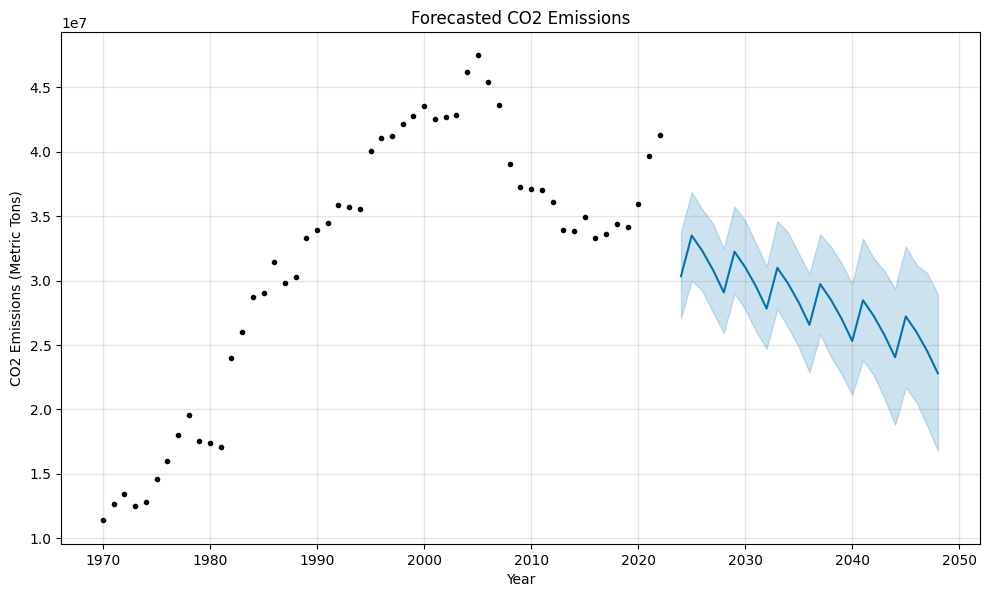

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/klkkkcs5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/1dngq5rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37240', 'data', 'file=/tmp/tmpy82iwmjq/klkkkcs5.json', 'init=/tmp/tmpy82iwmjq/1dngq5rs.json', 'output', 'file=/tmp/tmpy82iwmjq/prophet_modelvyff73_u/prophet_model-20250222034150.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

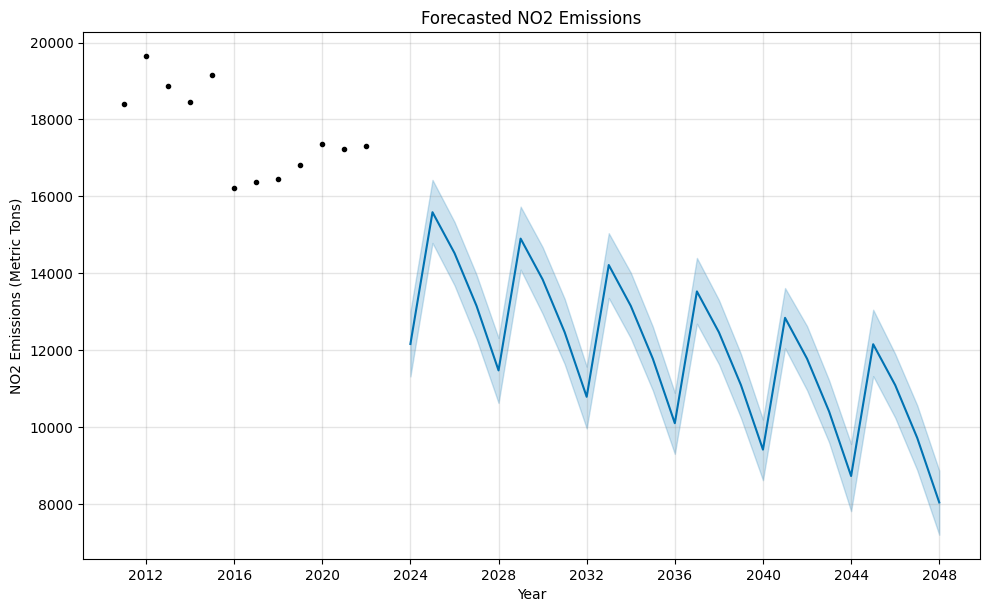

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/6e66_reh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy82iwmjq/wf2gximo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27741', 'data', 'file=/tmp/tmpy82iwmjq/6e66_reh.json', 'init=/tmp/tmpy82iwmjq/wf2gximo.json', 'output', 'file=/tmp/tmpy82iwmjq/prophet_modelz15ld0ti/prophet_model-20250222034151.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

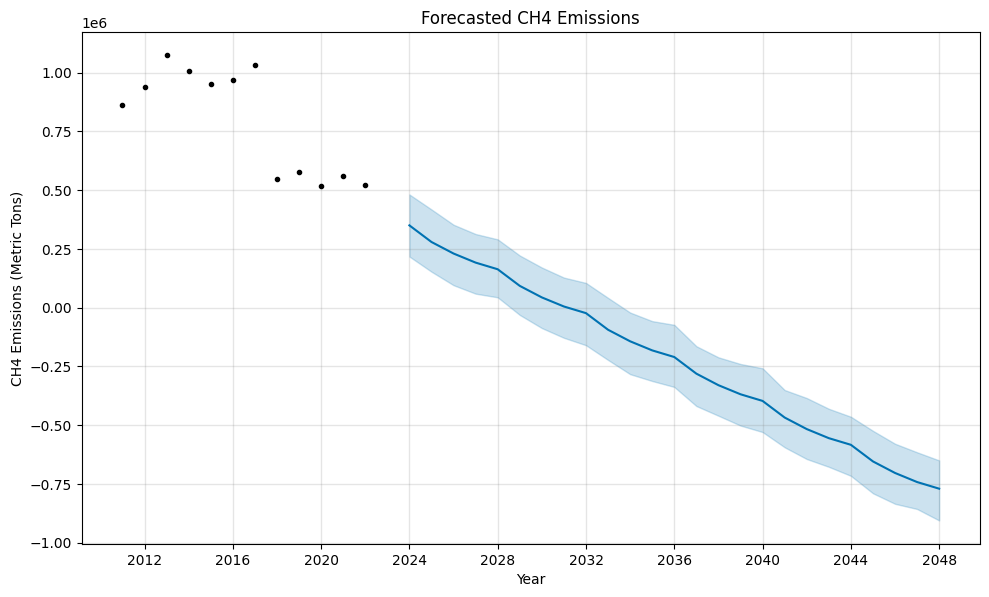

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the data
df_co2 = pd.read_csv("CO2.csv")
df_temp = pd.read_csv("Temp.csv")
df_no2 = pd.read_csv("NO2.csv")
df_ch4 = pd.read_csv("CH4.csv")

# Rename columns for consistency
df_co2.rename(columns={"MetricTons(CO2)": "CO2"}, inplace=True)
df_temp.rename(columns={"AvgHigh(°F)": "AvgHigh", "AvgLow(°F)": "AvgLow"}, inplace=True)
df_no2.rename(columns={"MetricTons(No2)(Co2equivalent)": "NO2"}, inplace=True)
df_ch4.rename(columns={"MetricTons(Ch4)(Co2equivalent)": "CH4"}, inplace=True)

# Merge datasets on 'Year'
df_merged = df_co2.merge(df_temp, on="Year", how="left") \
                   .merge(df_no2, on="Year", how="left") \
                   .merge(df_ch4, on="Year", how="left")

# Fill missing values using forward fill
df_merged.fillna(method='ffill', inplace=True)

#  train and forecast emissions
def train_and_forecast(df, target, regressors, periods=25):
    # Prepare data for Prophet
    df_prophet = df.rename(columns={"Year": "ds", target: "y"})
    df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

    # Initialize Prophet model
    model = Prophet(yearly_seasonality=True)
    for regressor in regressors:
        model.add_regressor(regressor)

    # Fit the model
    model.fit(df_prophet[["ds", "y"] + regressors])

    # Create future dataframe for predictions
    future = pd.DataFrame({"ds": pd.date_range(start=df_prophet["ds"].max() + pd.DateOffset(years=1),
                                               periods=periods, freq='Y')})

    # Generate future regressor values by using last available values
    for regressor in regressors:
        future[regressor] = df_prophet[regressor].iloc[-1]

    # Predict future values
    forecast = model.predict(future)

    # Plot results
    fig = model.plot(forecast)
    plt.title(f"Forecasted {target} Emissions")
    plt.xlabel("Year")
    plt.ylabel(f"{target} Emissions (Metric Tons)")
    plt.show()

    return forecast

# Forecast for CO2 emissions
forecast_co2 = train_and_forecast(df_merged, "CO2", ["AvgHigh", "AvgLow"])

# Forecast for NO2 emissions
forecast_no2 = train_and_forecast(df_merged, "NO2", ["AvgHigh", "AvgLow"])

# Forecast for CH4 emissions
forecast_ch4 = train_and_forecast(df_merged, "CH4", ["AvgHigh", "AvgLow"])

# Save results
forecast_co2.to_csv("forecast_co2.csv", index=False)
forecast_no2.to_csv("forecast_no2.csv", index=False)
forecast_ch4.to_csv("forecast_ch4.csv", index=False)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
